In [1]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

from utils.data_augmentation import rotate_keypoints
from utils.keypoints import read_keypoints, rescale_keypoints

from model.datasets import OneClassKeypointClassificationDataset
from model.transforms import RotateKeypoints
from model.models import StopPoseNet

import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler

from torch import nn
import torch.nn.functional as F

In [2]:
JSON_FILES_PATH = ['./data/labels/stop_pose/stop_pose_labelsSep-13-2020_2021.json']
JSON_KEYPOINTS_BASE_PATH = './data/keypoints/internal_resource_2323_fps10'
RANDOM_STATE = 42

N_EPOCHS = 3000
BATCH_SIZE = 32
LR = 0.00001

np.random.seed(RANDOM_STATE)

In [3]:
pd.set_option('display.max_colwidth', 200)
labels_json = None
for json_file in JSON_FILES_PATH:
    with open(json_file, 'r') as f:
        for row in f.readlines():
            labels_json = json.loads(row)

df = pd.DataFrame(labels_json)

def get_keypoints_path(file_path):
    file_basename = os.path.basename(file_path).split('.')[0]
    keypoints_path = os.path.realpath(os.path.join(JSON_KEYPOINTS_BASE_PATH, f'{file_basename}_keypoints.json'))
    
    return keypoints_path

df['keypoints_path'] = df['file_path'].apply(get_keypoints_path)
df

,file_path,stop_pose,keypoints_path
0,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_000047.jpg,1,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000047_keypoints.json
1,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_000048.jpg,1,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000048_keypoints.json
2,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_000049.jpg,1,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000049_keypoints.json
3,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_000050.jpg,1,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000050_keypoints.json
4,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_000051.jpg,1,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000051_keypoints.json
...,...,...,...
4025,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_004072.jpg,0,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_004072_keypoints.json
4026,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_004073.jpg,0,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_004073_keypoints.json
4027,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_004074.jpg,0,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_004074_keypoints.json
4028,/home/tom/Desktop/projects/sign-language/data/video_frames/internal_resource_2323_fps10/internal_resource_2323_004075.jpg,0,/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_004075_keypoints.json


In [4]:
print(df.keypoints_path[5])

/home/tom/Desktop/projects/sign-language/data/keypoints/internal_resource_2323_fps10/internal_resource_2323_000052_keypoints.json


In [5]:
keypoints = rescale_keypoints(read_keypoints(df.iloc[4025].keypoints_path))

print(keypoints.shape)

(57, 2)


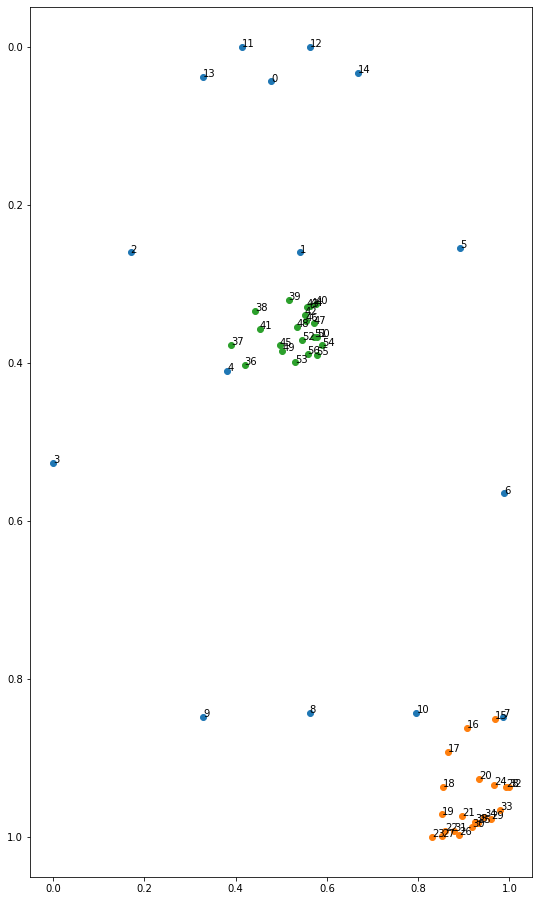

In [6]:
def plot_keypoints(new_keypoint):
    fig = plt.figure(figsize=(9,16))
    plt.scatter(new_keypoint[:15, 0], new_keypoint[:15, 1])
    plt.scatter(new_keypoint[15:15+21, 0], new_keypoint[15:15+21, 1])
    plt.scatter(new_keypoint[15+21:15+21+21, 0], new_keypoint[15+21:15+21+21, 1])

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.ylim(max(plt.ylim()), min(plt.ylim()))

    for i, row in enumerate(new_keypoint):

        if i < 15:
            text = f'pose-{i}'
        elif i < 36:
            text = f'left-hand-{i}'
        else:
            text = f'right-hand{i}' 

        plt.text(row[0], row[1], i)
        
plot_keypoints(keypoints)

In [7]:
def get_weights(df_train):
    class_sample_count = np.array([len(np.where(df_train.stop_pose==t)[0]) for t in np.unique(df_train.stop_pose)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in df_train.stop_pose])

    return torch.from_numpy(samples_weight)

In [8]:
# Train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

keypoints_transform_train = transforms.Compose([
    RotateKeypoints(-30, 30)
])

# Initialize Datasets
ds_train = OneClassKeypointClassificationDataset(df_train, keypoints_transform_train)
ds_test = OneClassKeypointClassificationDataset(df_test)

# Initialize Sampler
sampler = torch.utils.data.WeightedRandomSampler(get_weights(df_train), df_train.shape[0])

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)

# Model params
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = StopPoseNet().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [9]:
for row in train_dl:
    print(torch.flatten(row[1].float()).shape)
    break

torch.Size([32])


In [10]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    model.eval()
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        collect_results.append(pred.sigmoid().detach().cpu().numpy())
        collect_targets.append(y)

    preds_proba = np.concatenate(collect_results)
    preds = preds_proba.argmax(axis=1)
    targets = np.concatenate(collect_targets)

    ll = log_loss(targets, preds_proba)
    acc = accuracy_score(targets, preds)

    
    if print_info:
        print("test log-loss: {}".format(ll))
        print("overall accuracy:  {}".format(acc))

    model.train()
        
    return ll, acc

In [11]:
metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll, train_acc = evaluate_model(net, train_dl)
    test_ll, test_acc = evaluate_model(net, test_dl)
    
    
    print(f'train: loss={train_ll} acc={train_acc}')
    print(f'test: loss={test_ll} acc={test_acc}')
          
    metrics.append([train_ll, test_ll, train_acc, test_acc])

EPOCH=1
train: loss=0.6871538622207737 acc=0.49410669975186106
test: loss=0.6960972346014184 acc=0.24472704714640198
EPOCH=2
train: loss=0.6784776034892049 acc=0.7354218362282878
test: loss=0.6884205071971967 acc=0.6101116625310173
EPOCH=3
train: loss=0.6631102929303131 acc=0.8346774193548387
test: loss=0.6768661862789254 acc=0.7434863523573201
EPOCH=4
train: loss=0.6398415839849572 acc=0.8625930521091811
test: loss=0.6550863893429931 acc=0.7990074441687345
EPOCH=5
train: loss=0.5980287555133734 acc=0.885545905707196
test: loss=0.6228627065571011 acc=0.8126550868486352
EPOCH=6
train: loss=0.5480235256162234 acc=0.869727047146402
test: loss=0.579999984965357 acc=0.8148263027295285
EPOCH=7
train: loss=0.4908230761366506 acc=0.8843052109181141
test: loss=0.5234081384173546 acc=0.8306451612903226
EPOCH=8
train: loss=0.4365540041308619 acc=0.9103598014888338
test: loss=0.46871113944937365 acc=0.8526674937965261
EPOCH=9
train: loss=0.401730507025241 acc=0.9122208436724566
test: loss=0.425507

<AxesSubplot:>

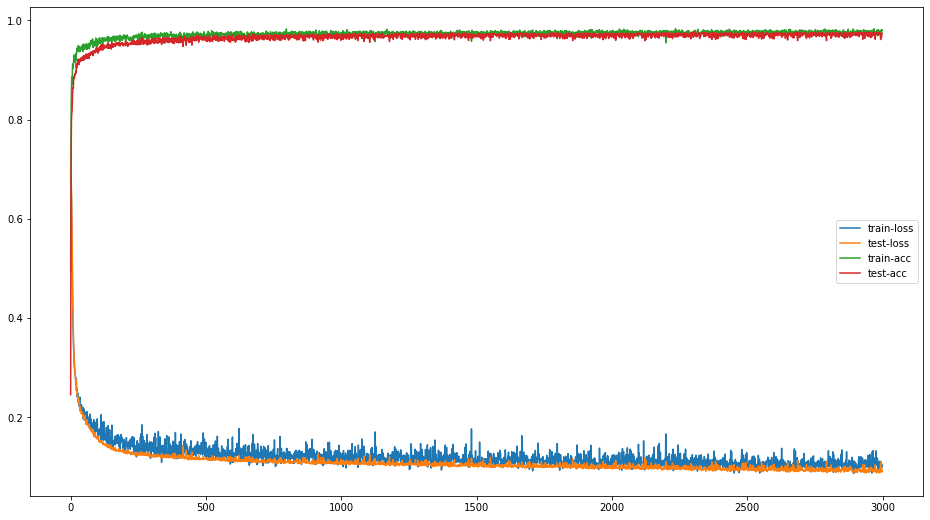

In [12]:
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss','train-acc','test-acc']).plot(subplots=False, figsize=(16,9))

In [13]:
torch.save(net.state_dict(), './model/stop_pose_detector.pt')

# m_state_dict = torch.load('mymodule.pt')
# new_m = MyModule()
# new_m.load_state_dict(m_state_dict)